# Train Forward Kinematics of 3DOF Planar Manipulator

In [78]:
%matplotlib notebook

from numpy import sin, cos
from functools import reduce
import numpy as np
from sklearn import gaussian_process as gp
from time import time
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes_lewiner as marching_cubes

## Robot Model
Implementing the forward kinematics of a planar robot with n degrees of freedom. 
The degrees of freedom are set by providing the link lengths list. E.g. doing this:
```python
r = Robot([1, 1, 0.5, 0.5])
```
creates a robot with 4 degrees of freedom.

In [71]:
class Robot(object):
    def __init__(self, link_lengths=[1, 1, 1]):
        self._link_lengths = link_lengths

    @staticmethod
    def __create_trafo(q, l):
        return np.array([[cos(q), -sin(q), l * cos(q)],
                         [sin(q), cos(q), l * sin(q)],
                         [0, 0, 1]])

    def forward_kinematics(self, joint_angles):
        trafos = [self.__create_trafo(q, l) for q, l in zip(joint_angles, self._link_lengths)]
        flange = reduce(lambda x, y: x.dot(y), trafos)
        return np.array([flange[0, 2], flange[1, 2], np.angle(np.exp(1j*(sum(joint_angles))))])

    def forward_kinematics_deg(self, joint_angles_deg):
        return self.forward_kinematics(np.deg2rad(joint_angles_deg))

### Testing the robot model

In [72]:
test_robot = Robot([1, 1, 1])
test_robot.forward_kinematics_deg([0, 90, 90])

array([0.        , 1.        , 3.14159265])

### Create a utility function creating coordinates of a hypercube grid:

In [73]:
def create_hypercube(dim, resolution):
    cube = np.array([np.linspace(0, 1, resolution)]).T
    for i in range(dim - 1):
        n = np.linspace(0, 1, resolution)
        tiled = np.tile(cube, (len(n), 1))
        repeated = np.repeat(n, cube.shape[0]).reshape((-1, 1))
        cube = np.hstack([repeated, tiled])
    return cube

create_hypercube(3, 2)

array([[0., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 1.],
       [1., 0., 0.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 1., 1.]])

## Gaussian Process Regression for Learning Forward Kinematics

The following class implements the regression of the forward kinematics. The training involves the following steps:
1. Sampling the configuration space uniformly
2. Call the robot forwards kinematics function for each sample to obtain training data
3. Train the gaussian process model

In [74]:
class ForwardKinematicsRegression(object):
    def __init__(self, dim=3, resolution=360):
        self._dim = dim
        self._resolution = resolution

    def fit(self, robot):
        g = gp.GaussianProcessRegressor()
        q = create_hypercube(self._dim, self._resolution)*2*np.pi
        forward_kin = np.apply_along_axis(robot.forward_kinematics, 1, q)
        print(f"Generated training set of {q.shape[0]} samples.")
        print("Start training...")
        tic = time()
        g.fit(q, forward_kin)
        print(f"Finished training after {time() - tic:.3f}s.")
        return g

## Perform the training for different amount of samples

The model is trained for different resolutions of the uniform sampling of the configuration space in order to compare the results:

In [75]:
models = {
    'rough': ForwardKinematicsRegression(resolution=6).fit(test_robot),
    'medium': ForwardKinematicsRegression(resolution=12).fit(test_robot),
    'fine': ForwardKinematicsRegression(resolution=24).fit(test_robot)
}

Generated training set of 216 samples.
Start training...
Finished training after 0.004s.
Generated training set of 1728 samples.
Start training...
Finished training after 0.130s.
Generated training set of 13824 samples.
Start training...
Finished training after 39.836s.


# Evaluate the Trained Models
The forward kinematics predicted by the Gaussian Process regressor are compared to the ground truth forward kinematics computed using the implemented robot model.
Therefore, random point in configuration space are sampled and the difference of predicted vs. ground truth data is computed.

In [9]:
def evaluate_model(key, model, n_samples=10000):
    gpr = model

    def do_sample():
        q = np.random.uniform(0, 2*np.pi, 3) # Sample a point in configuration space uniformly
        predicted = model.predict(q.reshape(1, -1)) # Use the regressor to predict the forward kinematics
        fkin = test_robot.forward_kinematics(q) # Compute the forward kinematics using the robot model
        return (predicted - fkin).flatten()
    
    tic = time()
    e = np.array([do_sample() for _ in range(n_samples)])
    dt = 1e3*(time() - tic)/n_samples
    print(f"Inference in the {key} GPR model takes {dt:.3f}ms per sample.")
    return e
    

errors = {k: evaluate_model(k, model) for k, model in models.items()}

Inference in the rough GPR model takes 0.123ms per sample.
Inference in the medium GPR model takes 0.139ms per sample.
Inference in the fine GPR model takes 0.229ms per sample.


### First, compute statistical data of the errors

In [10]:
def print_statistics(e):
    for i, coor in zip([0, 1, 2], ['x', 'y', 'ϕ']):
        d = np.abs(e[:,i])
        print(f"{coor}-direction:\tmax: {np.max(d):.6f}\taverage: {np.average(d):.6f}\tstddev: {np.std(d):.6f}")
        
for key, e in errors.items():
    print(f"Statistics using the {key} Gaussian Process Regressor:")
    print_statistics(e)
    print()

Statistics using the rough Gaussian Process Regressor:
x-direction:	max: 0.493473	average: 0.056348	stddev: 0.059376
y-direction:	max: 0.406183	average: 0.061831	stddev: 0.060932
ϕ-direction:	max: 3.538724	average: 0.614761	stddev: 0.716500

Statistics using the medium Gaussian Process Regressor:
x-direction:	max: 0.013520	average: 0.001180	stddev: 0.001611
y-direction:	max: 0.016224	average: 0.001355	stddev: 0.001873
ϕ-direction:	max: 3.933735	average: 0.462898	stddev: 0.560322

Statistics using the fine Gaussian Process Regressor:
x-direction:	max: 0.000022	average: 0.000001	stddev: 0.000002
y-direction:	max: 0.000029	average: 0.000001	stddev: 0.000002
ϕ-direction:	max: 3.204433	average: 0.356098	stddev: 0.542261



## Second, plot histogram on the errors

<IPython.core.display.Javascript object>


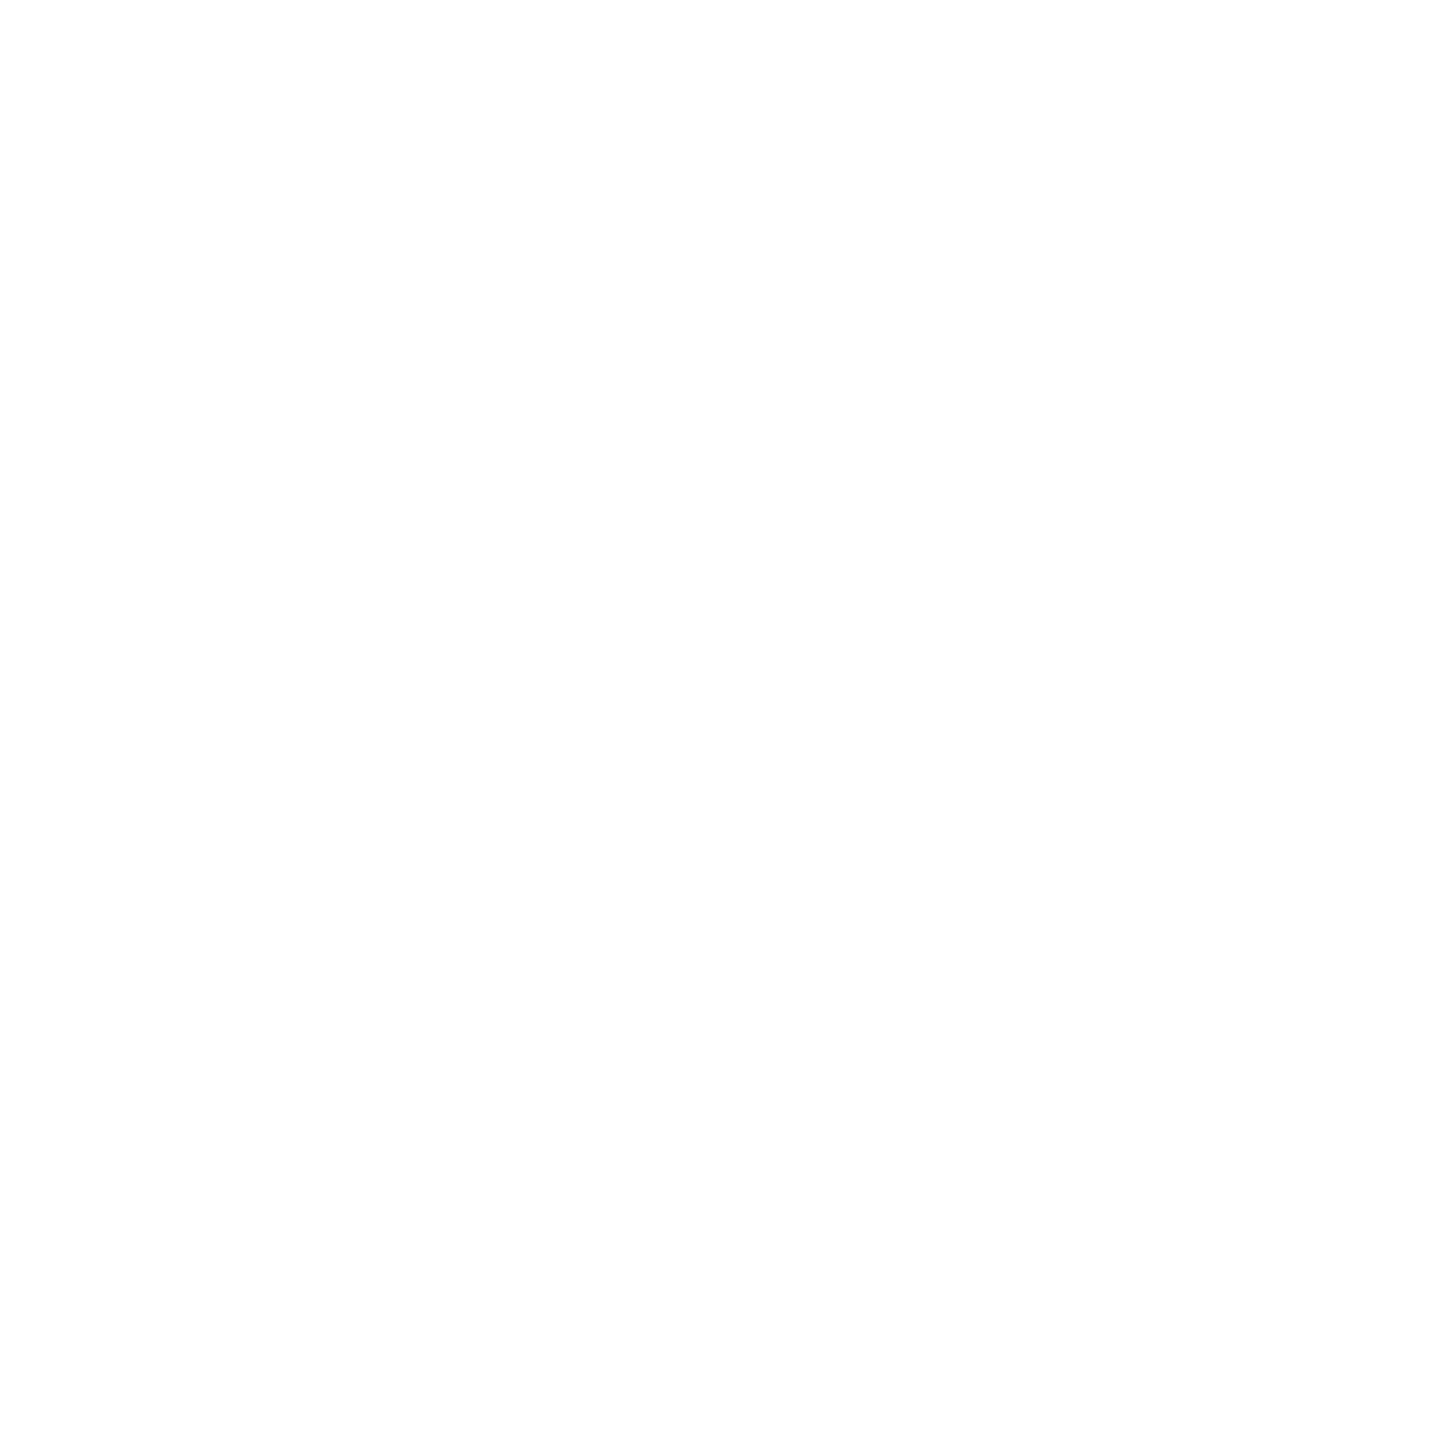

<IPython.core.display.Javascript object>


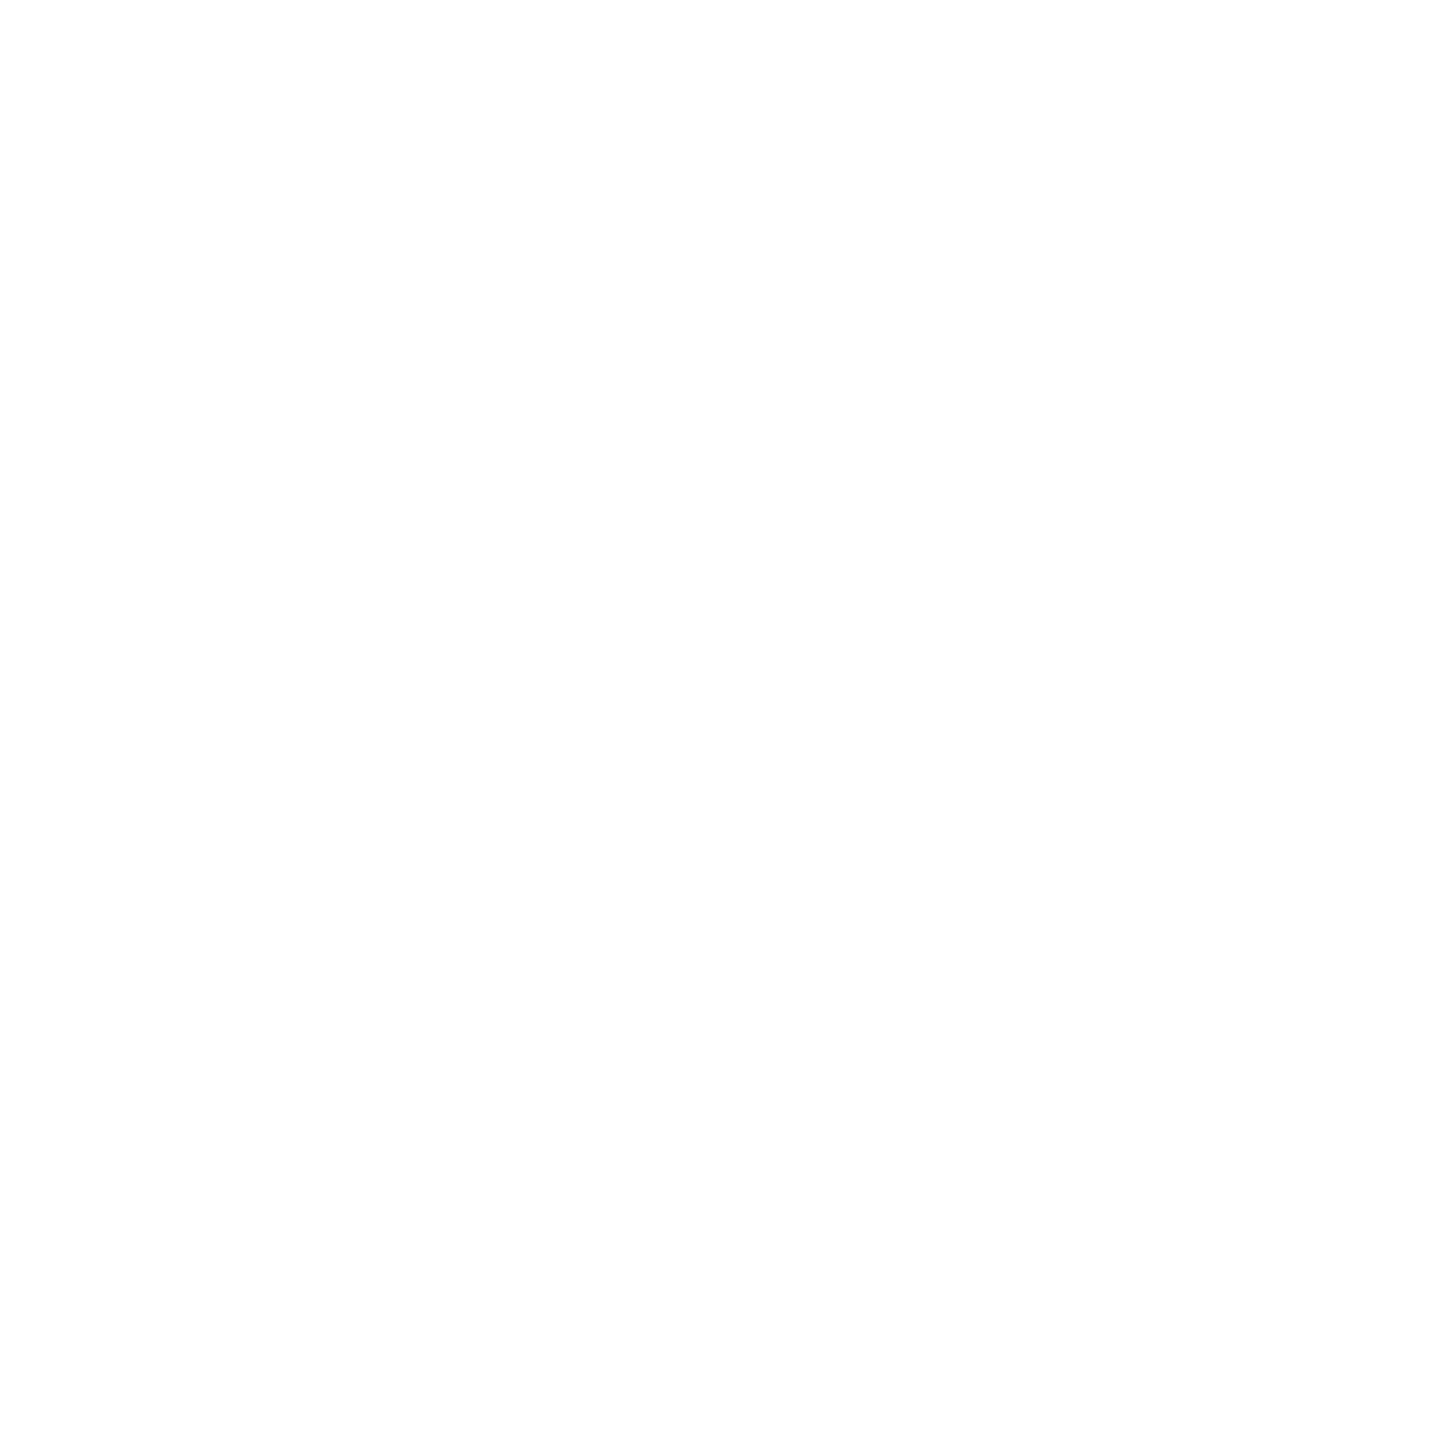

In [69]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(errors), 3, figsize=(20, 20))

for row, key in enumerate(errors.keys()):
    for index, coor in enumerate(['x', 'y', 'ϕ']):
        ax = axes[row, index]
        ax.hist(errors[key][:,index], bins=100)
        ax.set_title(f"Error in {coor}-direction using {key} GPR")
        ax.grid()
        if index in [0, 1]:
            ax.set_xlabel(f"Deviation in {coor}-direction in [m]")
        else:
            ax.set_xlabel(f"Orientation deviation in rad")

plt.show()

# Results of this vanilla approach

- I used the out-of-the-box Gaussian Process regressor, without any tuning of the kernel function
- *The prediction results are good for the tranlational components* (less than 10^-6 for the medium and fine GPR)
- The prediction results are bad for the rotational part given the representation used here

## Why is the orientation estimate bad

- Here, I use direct parametrization of the orientation in radians. There are discontinuities in the paramtrization
 - --> The performance is bad.
 
### How to make it better?
- Instead of using the raw angle in radians use sin and cos of the orientation in order to get a well-behaving function.
- In 3D use quaternions

# Training on well-behaved orientation of forward kinematics

Idea: The performance was bad in the orientation part. By making the function well-behaved using complex numbers, or quaternions in 3D, respectively it should be better to train on it.

In [12]:
class BetterForwardKinematicsRegression(object):
    def __init__(self, dim=3, resolution=360):
        self._dim = dim
        self._resolution = resolution

    def fit(self, robot):
        g = gp.GaussianProcessRegressor()

        q = create_hypercube(self._dim, self._resolution)*2*np.pi
        forward_kin = np.apply_along_axis(robot.forward_kinematics, 1, q)
        smooth_forward_kin = np.zeros((forward_kin.shape[0], 4))
        smooth_forward_kin[:,0:2] = forward_kin[:,0:2]
        smooth_forward_kin[:,2] = np.cos(forward_kin[:,2])
        smooth_forward_kin[:,3] = np.sin(forward_kin[:,2])
        print(f"Generated training set of {q.shape[0]} samples.")
        print("Start training...")
        tic = time()
        g.fit(q, smooth_forward_kin)
        print(f"Finished training after {time() - tic:.3f}s.")
        return g

In [13]:
better_models = {
    'rough': BetterForwardKinematicsRegression(resolution=6).fit(test_robot),
    'medium': BetterForwardKinematicsRegression(resolution=12).fit(test_robot),
    'fine': BetterForwardKinematicsRegression(resolution=24).fit(test_robot)
}

Generated training set of 216 samples.
Start training...
Finished training after 0.004s.
Generated training set of 1728 samples.
Start training...
Finished training after 0.176s.
Generated training set of 13824 samples.
Start training...
Finished training after 39.435s.


## Inference function transforming the orientation back to angles

In [29]:
def gp_inference(model, joint_angles):
    raw = model.predict(joint_angles.reshape(1, -1)).flatten()
    return np.array([raw[0], raw[1], np.arctan2(raw[3], raw[2])])

In [30]:
def evaluate_better_model(key, model, n_samples=10000):
    gpr = model

    def do_sample():
        q = np.random.uniform(0, 2*np.pi, 3) # Sample a point in configuration space uniformly
        predicted = gp_inference(model, q)
        fkin = test_robot.forward_kinematics(q) # Compute the forward kinematics using the robot model
        return (predicted - fkin).flatten()
    
    tic = time()
    e = np.array([do_sample() for _ in range(n_samples)])
    dt = 1e3*(time() - tic)/n_samples
    print(f"Inference in the better {key} GPR model takes {dt:.3f}ms per sample.")
    return e
    

errors_new = {k: evaluate_better_model(k, model) for k, model in better_models.items()}

Inference in the better rough GPR model takes 0.132ms per sample.
Inference in the better medium GPR model takes 0.157ms per sample.
Inference in the better fine GPR model takes 0.251ms per sample.


## Again, staticstical analysis of the errors
Now using the models trained on the smooth forward kinematics

In [31]:
for key, e in errors_new.items():
    print(f"Statistics using the {key} Gaussian Process Regressor on smooth forward kinematics:")
    print_statistics(e)
    print()

Statistics using the rough Gaussian Process Regressor on smooth forward kinematics:
x-direction:	max: 0.481150	average: 0.057582	stddev: 0.061066
y-direction:	max: 0.408913	average: 0.063950	stddev: 0.063139
ϕ-direction:	max: 6.281307	average: 0.085249	stddev: 0.484212

Statistics using the medium Gaussian Process Regressor on smooth forward kinematics:
x-direction:	max: 0.013495	average: 0.001192	stddev: 0.001666
y-direction:	max: 0.016339	average: 0.001314	stddev: 0.001813
ϕ-direction:	max: 6.282882	average: 0.002313	stddev: 0.088817

Statistics using the fine Gaussian Process Regressor on smooth forward kinematics:
x-direction:	max: 0.000025	average: 0.000001	stddev: 0.000002
y-direction:	max: 0.000025	average: 0.000001	stddev: 0.000002
ϕ-direction:	max: 0.000009	average: 0.000001	stddev: 0.000001



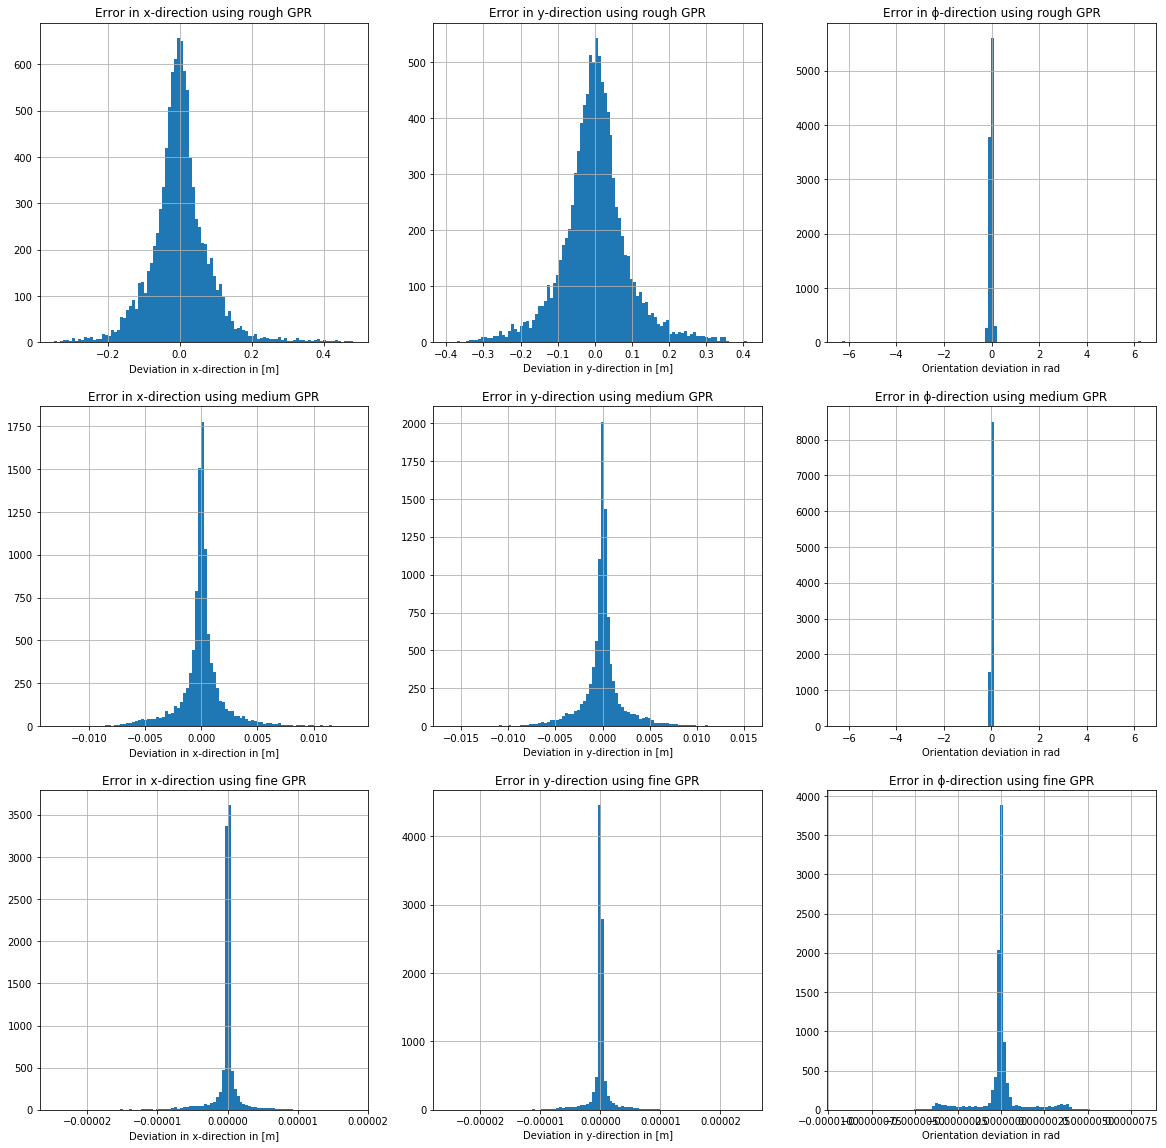

In [32]:
fig, axes = plt.subplots(len(errors_new), 3, figsize=(20, 20))

for row, key in enumerate(errors_new.keys()):
    for index, coor in enumerate(['x', 'y', 'ϕ']):
        ax = axes[row, index]
        ax.hist(errors_new[key][:,index], bins=100)
        ax.set_title(f"Error in {coor}-direction using {key} GPR")
        ax.grid()
        if index in [0, 1]:
            ax.set_xlabel(f"Deviation in {coor}-direction in [m]")
        else:
            ax.set_xlabel(f"Orientation deviation in rad")

plt.show()

# Results of the trained model on smooth forward kinematics

- I trained the gaussian process model on uniformly sampled configuration space
- For evalutation of the trained models, I use randomly sampled points in configuration space
- The prediction is now good for both tranlation and orientation
 - maximum error for x direction is < 1.4*10^-5m
 - maximum error for y direction is < 2.8*10^-5m
 - maximum error for ϕ is < 9*10^-6 rad

## Show the used kernel function

First, select the best model

In [28]:
m = better_models['fine']

m.predict(np.array([0, 0, 0]).reshape(1, -1))

array([[ 3.00000039e+00,  5.82683466e-08,  1.00000023e+00,
        -2.29421586e-07]])

## Kernel with optimized hyperparameters used in the Gaussian Process

In [18]:
m.kernel_

1**2 * RBF(length_scale=1)

# Marching Cubes to plot the manifold given as implicit function

Problem: We have a implicit function, which is not trivial to plot. For example let $x_0 = 1$, then we wanna plot $f(q)_x = x_0$.

Idea: Use **marching cubes** to plot the implicit function.

## Plot an implicit function

In [103]:
def evaluate_on_volume(func, interval, resolution):
    data = np.zeros((resolution, resolution, resolution))
    ax = np.linspace(interval[0], interval[1], resolution)
    for i1, x1 in enumerate(ax):
        for i2, x2 in enumerate(ax):
            for i3, x3 in enumerate(ax):
                data[i1, i2, i3] = func(np.array([x1, x2, x3]))
    return data

def plot_implicit_function(ax, func, level, 
                           interval=(0, 2*np.pi), 
                           resolution=24, 
                           color=((0.5, 0.5, 0.5, 0.5))):
    volume = evaluate_on_volume(func, interval, resolution)
    verts, faces, normals, values = marching_cubes(volume, level)
    mesh = Poly3DCollection(verts[faces])
    mesh.set_facecolor(color)
    ax.add_collection3d(mesh)
    for i in [ax.set_xlim, ax.set_ylim, ax.set_zlim]:
        i(0, resolution)
    for g, s in zip([ax.get_xticks, ax.get_yticks, ax.get_zticks],
                    [ax.set_xticklabels, ax.set_yticklabels, ax.set_zticklabels]):
        s([f"{v:3f}" for v in (g() * (interval[1] - interval[0]) / resolution + interval[0])])

<IPython.core.display.Javascript object>


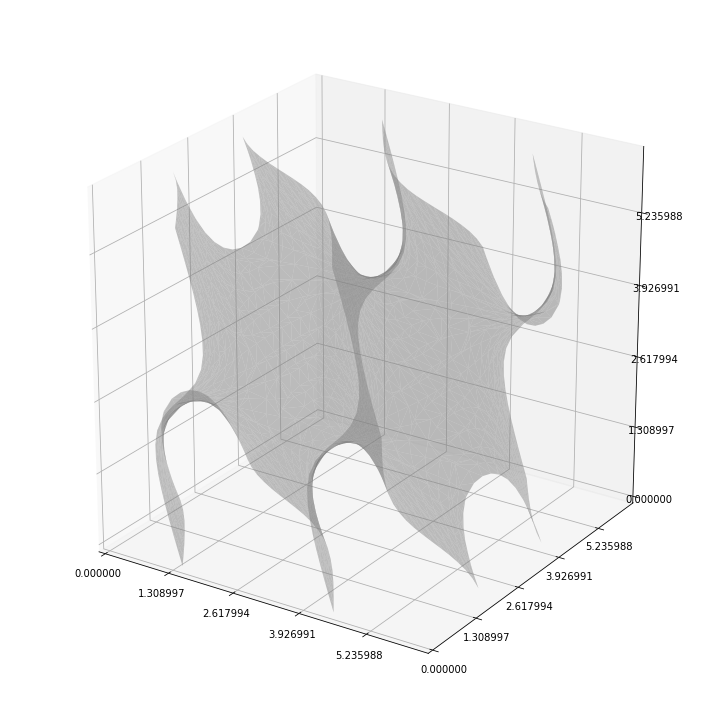

In [117]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

plot_implicit_function(ax, lambda x: gp_inference(m, x)[0], 0.0)
plt.tight_layout()
plt.show()
